In [26]:
from sea_breeze import sea_breeze_filters, load_model_data, sea_breeze_funcs, utils
from dask.distributed import Client
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import glob
import geopandas
import numpy as np
import logging
import datetime as dt
import pandas as pd

In [2]:
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46583 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46583/status,
Dashboard: /proxy/46583/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43271,Workers: 7
Dashboard: /proxy/46583/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:43281,Total threads: 1
Dashboard: /proxy/42313/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:40597,


2025-06-16 11:10:04,296 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-mask-51037204c4007650d9fc3571776ec965' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: DataNode(original-open_dataset-mask-51037204c4007650d9fc3571776ec965, type=<class 'xarray.core.indexing.ImplicitToExplicitIndexingAdapter'>, ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=BoolTypeArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x1511a2828040>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, Non

In [3]:
uname = "ua100m"
vname = "va100m"

In [62]:
lat_slice = slice(-45,-30)
lon_slice = slice(135,155)

In [5]:
ds_nov_apr = xr.open_mfdataset(
    np.sort(
        glob.glob("/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_"+uname+"_"+vname+"_????11*.nc") +\
        glob.glob("/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_"+uname+"_"+vname+"_????12*.nc") +\
        glob.glob("/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_"+uname+"_"+vname+"_????01*.nc") +\
        glob.glob("/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_"+uname+"_"+vname+"_????02*.nc") +\
        glob.glob("/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_"+uname+"_"+vname+"_????03*.nc") +\
        glob.glob("/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_perturbation_"+uname+"_"+vname+"_????04*.nc")),
    concat_dim="month",
    combine="nested"
).sel(lat=lat_slice,lon=lon_slice)

vprime_nov_apr = ds_nov_apr.vprime_pert.mean("month").persist()
cf_nov_apr = ds_nov_apr.cf_pert.mean("month").persist()

In [63]:
angle_ds = load_model_data.get_coastline_angle_kernel(
    compute=False,
    path_to_load="/g/data/ng72/ab4502/coastline_data/barra_c.nc",
    lat_slice=lat_slice,
    lon_slice=lon_slice)

orog,lsm = load_model_data.load_barra_static("AUST-04",lon_slice,lat_slice)
min_coast_dist = xr.where(lsm,angle_ds.min_coast_dist,-angle_ds.min_coast_dist)

In [7]:
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

offshore_regions = geopandas.read_file("/g/data/ng72/ab4502/coastline_data/Offshore_Renewable_Energy_Infrastructure_Regions/Offshore_Renewable_Energy_Infrastructure_Regions.shp")
onshore_regions = geopandas.read_file("/g/data/ng72/ab4502/coastline_data/Indicative REZ boundaries 2024 GIS data (1).kml")


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/g/data/xp65/public/apps/med_conda/envs/ana

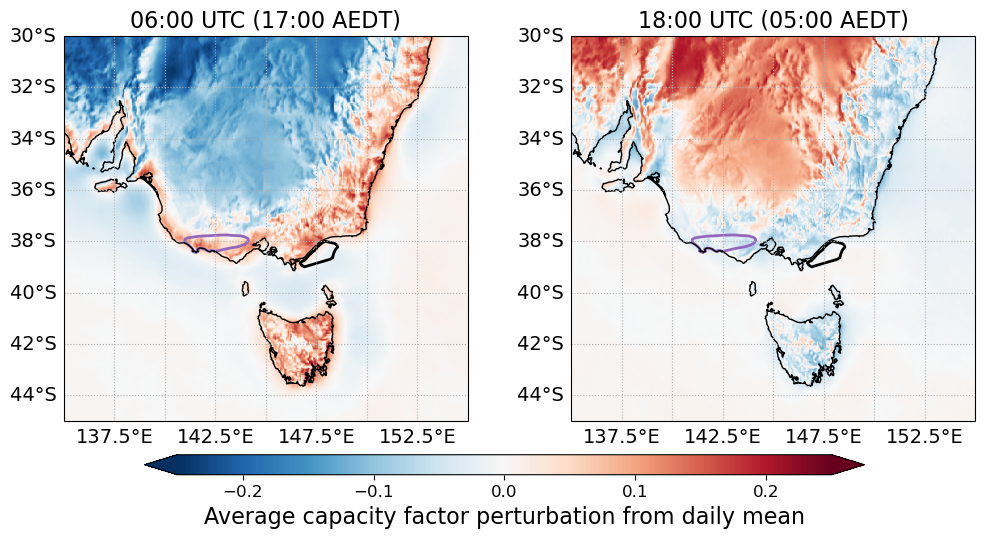

In [16]:
def plot_offshore_regions(ax):
    #geopandas.GeoDataFrame(offshore_regions).loc[[1],"geometry"].plot(ax=ax,facecolor="none",edgecolor="tab:red",lw=2,ls="-")
    #geopandas.GeoDataFrame(offshore_regions).loc[[2],"geometry"].plot(ax=ax,facecolor="none",edgecolor="k",lw=1.5,ls=":")
    geopandas.GeoDataFrame(offshore_regions).loc[[3],"geometry"].plot(ax=ax,facecolor="none",edgecolor="k",lw=2,ls="-")

def plot_onshore_regions(ax):
    geopandas.GeoDataFrame(onshore_regions).loc[[24],"geometry"].plot(ax=ax,facecolor="none",edgecolor="tab:purple",lw=2,ls="-")

plt.figure(figsize=[12,5])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
cf_nov_apr.sel(hour=5).plot(vmin=-0.25,vmax=0.25,cmap="RdBu_r",extend="both",add_colorbar=False)
#xr.plot.contour(orog, levels=[250], colors="k", linewidths=0.5)
#xr.plot.contourf(orog,levels=[500,10000],extend="neither",colors=["k"],alpha=0.2,hatches=["//"],add_colorbar=False)
ax.coastlines(lw=1)
ax.gridlines(ls=":",draw_labels=["bottom","left"],xlabel_style={"size":14},ylabel_style={"size":14})
plot_offshore_regions(ax)
plot_onshore_regions(ax)
plt.title("06:00 UTC (17:00 AEDT)",size=16)

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
c = cf_nov_apr.sel(hour=18).plot(vmin=-0.25,vmax=0.25,cmap="RdBu_r",extend="both",add_colorbar=False)
#xr.plot.contourf(orog,levels=[500,10000],extend="neither",colors=["k"],alpha=0.2,hatches=["//"],add_colorbar=False)
#xr.plot.contour(orog, levels=[500], colors="k", linewidths=0.5)
ax.coastlines()
ax.gridlines(ls=":",draw_labels=["bottom","left"],xlabel_style={"size":14},ylabel_style={"size":14})

plot_offshore_regions(ax)
plot_onshore_regions(ax)
plt.title("18:00 UTC (05:00 AEDT)",size=16)

cax = plt.axes([0.2,0.002,0.6,0.04])
cb=plt.colorbar(c,cax=cax,orientation="horizontal",extend="both")
cb.set_label("Average capacity factor perturbation from daily mean",size=16)
cb.ax.tick_params(labelsize=12)

plt.savefig("/g/data/ng72/ab4502/figs/amos_poster_fig3.jpeg",dpi=600,bbox_inches="tight")

In [11]:
shapes = [(shape, n) for n, shape in enumerate(offshore_regions.iloc[[1,2,3]].geometry)]
offshore_raster = rasterize(shapes,lsm.coords,fill=np.nan)

shapes = [(shape, n) for n, shape in enumerate(onshore_regions.iloc[[24]].geometry)]
onshore_raster = rasterize(shapes,lsm.coords,fill=np.nan)

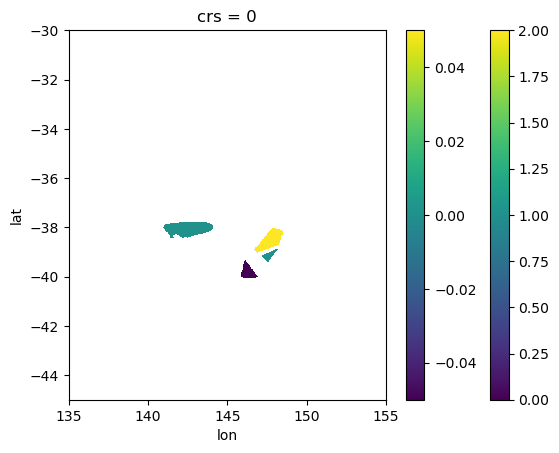

In [12]:
offshore_raster.plot()
onshore_raster.plot()

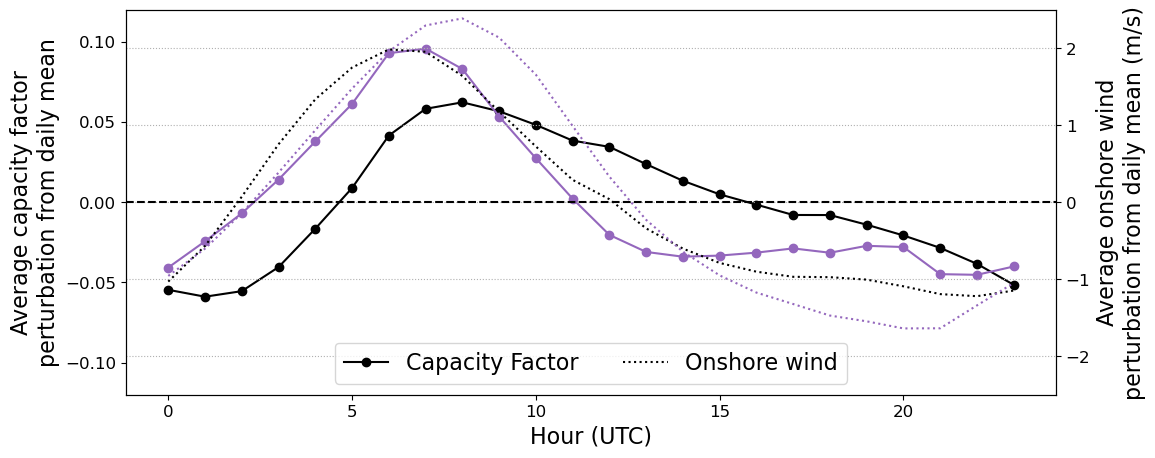

In [17]:
plt.figure(figsize=[12,5])
ax1=plt.axes()
ax2=ax1.twinx()

l1=xr.where((offshore_raster==2),cf_nov_apr,np.nan).mean(("lat","lon")).plot(color="k",marker="o",ax=ax1)
l2=xr.where((offshore_raster==2),vprime_nov_apr,np.nan).mean(("lat","lon")).plot(color="k",marker="none",ax=ax2,ls=":")
#xr.where(offshore_raster==0,cf_nov_apr,np.nan).mean(("lat","lon")).plot(color="tab:red",marker="o",ax=ax1)
#xr.where(offshore_raster==0,vprime_nov_apr,np.nan).mean(("lat","lon")).plot(color="tab:red",marker="none",ax=ax2,ls=":")
xr.where(onshore_raster==0,cf_nov_apr,np.nan).mean(("lat","lon")).plot(color="tab:purple",marker="o",ax=ax1)
xr.where(onshore_raster==0,vprime_nov_apr,np.nan).mean(("lat","lon")).plot(color="tab:purple",marker="none",ax=ax2,ls=":")
plt.gca().grid(ls=":")
plt.gca().axhline(ls="--",color="k")
ax1.set_title("")
ax2.set_title("")
ax1.set_ylabel("Average capacity factor\nperturbation from daily mean",size=16)
ax2.set_ylabel("Average onshore wind\nperturbation from daily mean (m/s)",size=16)
ax1.set_xlabel("Hour (UTC)",size=16)
ax1.set_ylim([-.12,.12])
ax2.set_ylim([-2.5,2.5])

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

plt.legend([l1[0],l2[0]],["Capacity Factor","Onshore wind"],ncols=2,loc="lower center",fontsize=16)

plt.savefig("/g/data/ng72/ab4502/figs/amos_poster_fig4.jpeg",dpi=600,bbox_inches="tight")

In [18]:
f = xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/filters/filtered_mask_no_hourly_change_F_*",
                     engine="zarr").sel(lat=lat_slice,lon=lon_slice)

In [19]:
fsum = f.groupby(f.time.dt.date).max().mask.sum("date").persist()

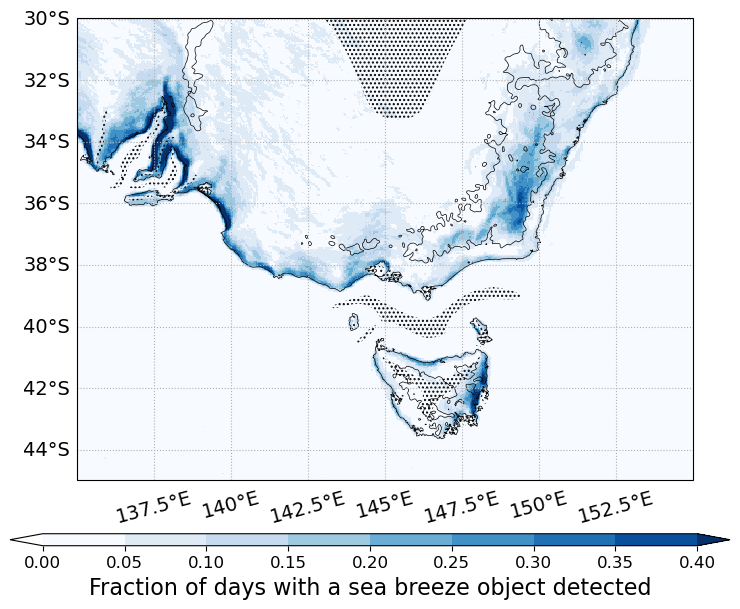

In [64]:
plt.figure(figsize=[12,6])


#levels = [0,0.04,0.08,0.12,0.16,0.02,0.24,0.28,0.32]
levels = np.arange(0,0.45,0.05)

ax=plt.axes(projection=ccrs.PlateCarree())
c=(fsum/len(np.unique(f.time.dt.date))).sel(lat=lat_slice,lon=lon_slice).plot(cmap="Blues",levels=levels,add_colorbar=False)
#xr.plot.contourf(orog.sel(lat=lat_slice,lon=lon_slice),levels=[500,10000],extend="neither",colors=["grey"],alpha=0.2,hatches=["//"],add_colorbar=False)
xr.plot.contour(orog.sel(lat=lat_slice,lon=lon_slice),levels=[500],colors=["k"],linewidths=0.5,add_colorbar=False)
xr.plot.contourf(angle_ds.variance_interp.sel(lat=lat_slice,lon=lon_slice),levels=[0.5,1],extend="neither",colors=["none"],alpha=0,hatches=["...."],add_colorbar=False)
ax.coastlines(lw=0.5)

#plt.plot(p_lon,p_lat,marker="x",color="k")
ax.gridlines(ls=":",draw_labels=["bottom","left"],xlabel_style={"size":14,"rotation":15},ylabel_style={"size":14})

cax = plt.axes([0.2,0.001,0.6,0.02])
cb=plt.colorbar(c,cax=cax,orientation="horizontal",extend="both")
cb.set_label("Fraction of days with a sea breeze object detected",size=16)
cb.ax.tick_params(labelsize=12)

plt.savefig("/g/data/ng72/ab4502/figs/amos_poster_fig5a.jpeg",dpi=600,bbox_inches="tight")

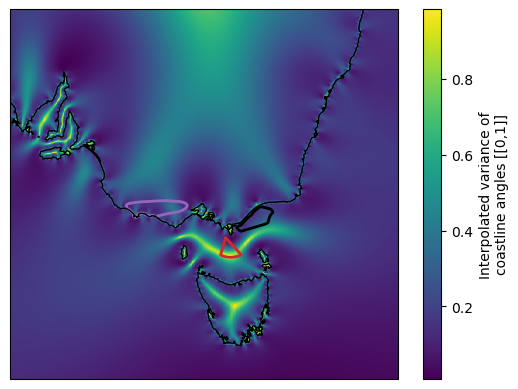

In [53]:
ax=plt.axes(projection=ccrs.PlateCarree())

angle_ds.variance_interp.plot()
plot_offshore_regions(ax)
plot_onshore_regions(ax)
ax.coastlines()

In [51]:
def preprocess(ds):
    ds["time"] = pd.to_datetime(ds.time) + dt.timedelta(hours=11)
    #return ds["mask"].resample({"time":"1D"}).max()
    return ds["mask"].groupby(ds.time.dt.date).max()

def load_hourly(model,lat_slice,lon_slice,diagnostic,lt_offset,chunks={"time":10}):

    ds = xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+\
                      model+\
                      "/filters/filtered_mask_no_hourly_change_"+\
                      diagnostic+\
                      "_*.zarr/",
                 chunks=chunks, engine="zarr").sel(lat=lat_slice,lon=lon_slice)
    ds["time"] = pd.to_datetime(ds.time) + dt.timedelta(hours=lt_offset)
    
    return ds

def count_num_of_objs(da):
    x = np.unique(da)
    x = x[x!=0]
    x = x[~np.isnan(x)]
    return len(x)

def mask(ds,angle_ds,mask=True,mask_thresh=0.5):
    return xr.where(angle_ds.variance_interp<mask_thresh, ds, np.nan)    

def load_data(lat_slice,lon_slice,sb_lat_slice=None,sb_lon_slice=None):
        
    m="barra_c"
    angle_ds = load_model_data.get_coastline_angle_kernel(
        compute=False,
        path_to_load="/g/data/ng72/ab4502/coastline_data/"+m+".nc",
        lat_slice=lat_slice,
        lon_slice=lon_slice
    )
    #orog,lsm = load_model_data.load_aus2200_static("mjo-elnino2016",lon_slice,lat_slice)   
    orog,lsm = load_model_data.load_barra_static("AUST-04",lon_slice,lat_slice)

    lst_offset = np.round(np.mean(lsm.lon.values) / 180 * 12)

    m = "barra_c_smooth_s2"
    c = {}
    
    F_hourly = load_hourly(m,lat_slice,lon_slice,"F",lst_offset,chunks=c)
    F_hourly = xr.where((F_hourly.time.dt.hour < 9) | (F_hourly.time.dt.hour > 21), 0, F_hourly)
    F = F_hourly.groupby(F_hourly.time.dt.date).max().persist()

    #Define sea breeze days where at least one of the grid points within 50 km of the coastline have a sea breeze object
    if sb_lat_slice is None:
        sb_lat_slice = lat_slice
    if sb_lon_slice is None:
        sb_lon_slice = lon_slice
    F_sb_ts = (xr.where(
        (angle_ds.min_coast_dist<=50), F.mask, np.nan
        ).sel(lat=sb_lat_slice,lon=sb_lon_slice).mean(("lat","lon")) > 0.0).values 

    #Load model data for the period
    uas = []
    vas = []
    tas = []
    hus = []
    times = [("2013-01-01 00:00","2013-02-28 23:00"),
             ("2016-01-01 00:00","2016-02-29 23:00"),
             ("2018-01-01 00:00","2018-02-28 23:00")]
    expid = ["mjo-neutral2013","mjo-elnino2016","mjo-lanina2018"]
    for t,e in zip(times,expid):
    
        vas.append(load_model_data.load_barra_variable(
                    "vas",
                    t[0],
                    t[1],
                    "AUST-04",
                    "1hr",
                    lat_slice,
                    lon_slice,
                    chunks={}))
    
        uas.append(load_model_data.load_barra_variable(
                    "uas",
                    t[0],
                    t[1],
                    "AUST-04",
                    "1hr",
                    lat_slice,
                    lon_slice,
                    chunks={}))
        
    vas = xr.concat(vas,dim="time")
    uas = xr.concat(uas,dim="time")

    #Add local time offset
    uas["time"] = pd.to_datetime(uas.time) + dt.timedelta(hours=lst_offset)
    vas["time"] = pd.to_datetime(vas.time) + dt.timedelta(hours=lst_offset)

    #Calculate wind speed
    ws = np.sqrt(uas**2+vas**2)
    
    #Composite the model data over the sea breeze days defined by F
    sb_hourly_times = (np.in1d(uas.time.dt.date,F.date[F_sb_ts.astype(bool)]))
    vas_F_sb_comp = vas.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
    uas_F_sb_comp = uas.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
    ws_F_sb_comp = ws.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
    F_sb_comp = {"uas":uas_F_sb_comp,
                 "vas":vas_F_sb_comp,
                 "ws":ws_F_sb_comp}

    #Composite the model data over non sea breeze days defined by F
    nonsb_hourly_times = (np.in1d(uas.time.dt.date,F.date[~F_sb_ts.astype(bool)]))
    vas_F_nonsb_comp = vas.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()
    uas_F_nonsb_comp = uas.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()
    ws_F_nonsb_comp = ws.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()
    F_non_sb_comp = {
                 "uas":uas_F_nonsb_comp,
                 "vas":vas_F_nonsb_comp,
                 "ws":ws_F_nonsb_comp}
    
    return F_hourly, F, angle_ds, lsm, orog, F_sb_ts, F_sb_comp, F_non_sb_comp


def plot_bbox(lat_slice,lon_slice):
    plt.plot(
    [lon_slice.start,lon_slice.stop,lon_slice.stop,lon_slice.start,lon_slice.start],
    [lat_slice.start,lat_slice.start,lat_slice.stop,lat_slice.stop,lat_slice.start],
    color="k",
    ls=":"
    )

def plot_sbdays_box(angle_ds,sb_lat_slice,sb_lon_slice):

    xr.plot.contour(
        xr.where(
        (angle_ds.min_coast_dist.lat<sb_lat_slice.stop) &
            (angle_ds.min_coast_dist.lat>sb_lat_slice.start) & 
            (angle_ds.min_coast_dist.lon>sb_lon_slice.start) & 
            (angle_ds.min_coast_dist.lon<sb_lon_slice.stop),
        angle_ds.min_coast_dist,100),
        levels=[50],colors="k",linestyles="--")    

In [52]:
sb_lat_slice, sb_lon_slice = utils.get_gippsland_bounds()
sb_lon_slice = slice(146.6,149.3)

lat_slice = slice(-42,-35)
lon_slice = slice(144.20,151.9)


F_hourly, F, angle_ds, lsm, orog, F_sb_ts, F_sb_comp, F_non_sb_comp = load_data(lat_slice,lon_slice,sb_lon_slice=sb_lon_slice,sb_lat_slice=sb_lat_slice)

In [53]:
print(F_sb_ts.sum(), F.date.shape[0])

117 181


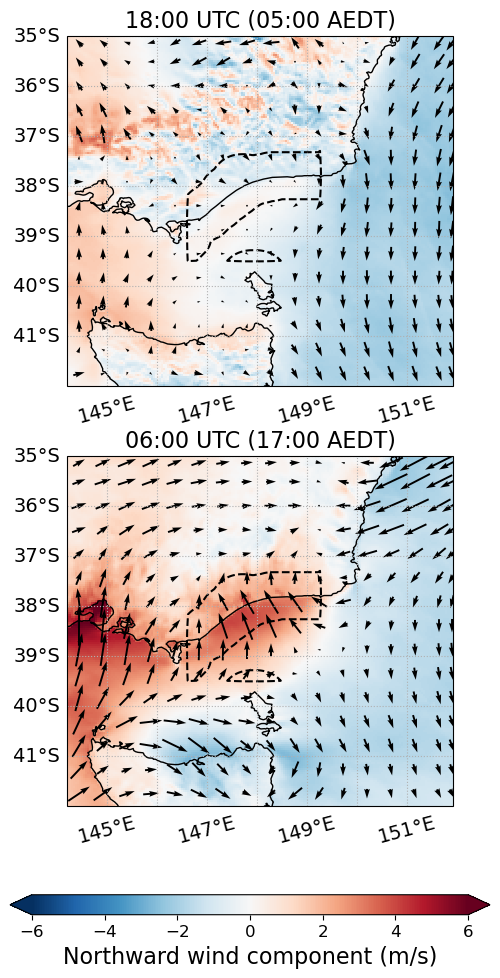

In [54]:
h = 4
s = 50
c=12

plt.figure(figsize=[8,10])
ax=plt.subplot(2,1,1,projection=ccrs.PlateCarree())
cont=F_sb_comp["vas"].sel(hour=h).plot(cmap="RdBu_r",ax=ax,vmin=-6,vmax=6,add_colorbar=False)
xr.Dataset({
    "u":F_sb_comp["uas"],
    "v":F_sb_comp["vas"]}).coarsen({"lat":c,"lon":c},boundary="pad").mean().sel(hour=h).plot.quiver(
    x="lon",y="lat",u="u",v="v",ax=ax,width=0.005,scale=s)
ax.coastlines()
plot_sbdays_box(angle_ds,sb_lat_slice,sb_lon_slice)
ax.gridlines(ls=":",draw_labels=["bottom","left"],xlabel_style={"size":14,"rotation":15},ylabel_style={"size":14})
plt.title("18:00 UTC (05:00 AEDT)",size=16)

h=16

ax=plt.subplot(2,1,2,projection=ccrs.PlateCarree())
F_sb_comp["vas"].sel(hour=h).plot(cmap="RdBu_r",ax=ax,vmin=-6,vmax=6,add_colorbar=False)
xr.Dataset({
    "u":F_sb_comp["uas"],
    "v":F_sb_comp["vas"]}).coarsen({"lat":c,"lon":c},boundary="pad").mean().sel(hour=h).plot.quiver(
    x="lon",y="lat",u="u",v="v",ax=ax,width=0.005,scale=s)
ax.coastlines()
plot_sbdays_box(angle_ds,sb_lat_slice,sb_lon_slice)
ax.gridlines(ls=":",draw_labels=["bottom","left"],xlabel_style={"size":14,"rotation":15},ylabel_style={"size":14})
plt.title("06:00 UTC (17:00 AEDT)",size=16)

cax = plt.axes([0.2,0.001,0.6,0.02])
cb=plt.colorbar(cont,cax=cax,orientation="horizontal",extend="both")
cb.set_label("Northward wind component (m/s)",size=16)
cb.ax.tick_params(labelsize=12)
cb.ax.tick_params(labelsize=12)

plt.savefig("/g/data/ng72/ab4502/figs/amos_poster_fig5b.jpeg",dpi=600,bbox_inches="tight")

In [55]:
coastal_mask = (angle_ds.min_coast_dist.lat<sb_lat_slice.stop) & \
        (angle_ds.min_coast_dist.lat>sb_lat_slice.start) & \
        (angle_ds.min_coast_dist.lon>sb_lon_slice.start) & \
        (angle_ds.min_coast_dist.lon<sb_lon_slice.stop) & \
        (angle_ds.min_coast_dist<=50)

Text(0.5, 1.0, 'V wind component')

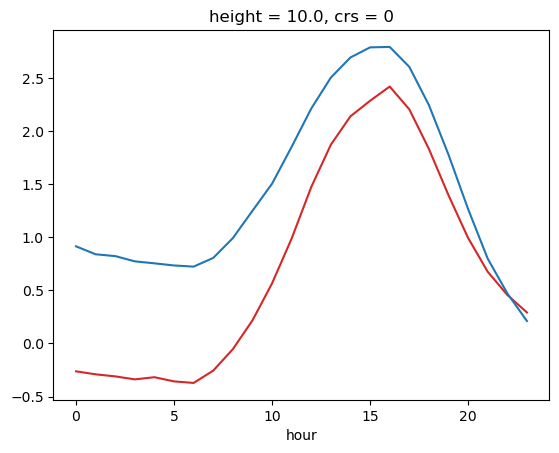

In [56]:
xr.where(coastal_mask, F_sb_comp["vas"], np.nan).mean(("lat","lon")).plot(color="tab:red")
xr.where(coastal_mask, F_non_sb_comp["vas"], np.nan).mean(("lat","lon")).plot(color="tab:blue")
ax.grid(ls=":")
ax.set_xlabel("")
ax.set_title("V wind component")

Text(0.5, 1.0, 'V wind component')

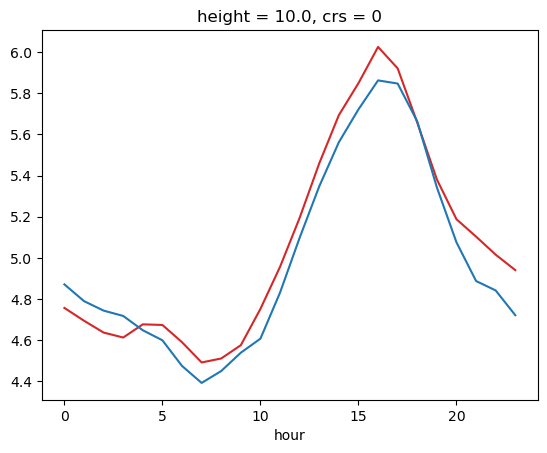

In [60]:
xr.where(coastal_mask, F_sb_comp["ws"], np.nan).mean(("lat","lon")).plot(color="tab:red")
xr.where(coastal_mask, F_non_sb_comp["ws"], np.nan).mean(("lat","lon")).plot(color="tab:blue")
ax.grid(ls=":")
ax.set_xlabel("")
ax.set_title("V wind component")

Text(0.5, 1.0, 'V wind component')

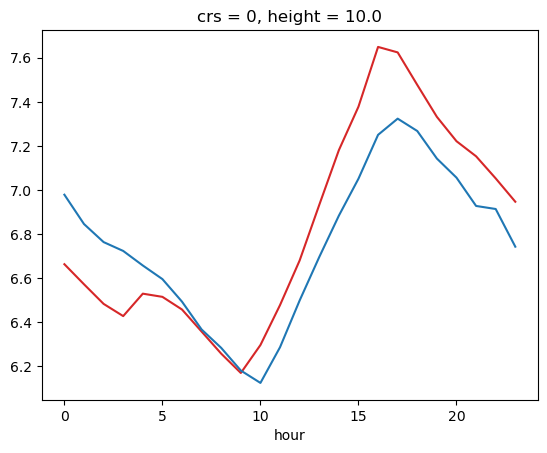

In [59]:
xr.where(coastal_mask & ~lsm, F_sb_comp["ws"], np.nan).mean(("lat","lon")).plot(color="tab:red")
xr.where(coastal_mask & ~lsm, F_non_sb_comp["ws"], np.nan).mean(("lat","lon")).plot(color="tab:blue")
ax.grid(ls=":")
ax.set_xlabel("")
ax.set_title("V wind component")